In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tsod import MVCorrelationDetector

This notebook shows an example of using cross-correlation between time series to detect anomalies.

# Generate normal and abnormal data

We generate data from three time series. The time series in rows 1 and 2 ($ts_1$ and $ts_2$) are defined as independent Gaussian observations with mean 2 and standard deviation 0.1. Hence these two time series are uncorrelated. We define the row 0 time series as a function of the two other time series: $ts_0 = 3ts_1 + ts_2$, making $ts_0$ correlated with both $ts_1$ and $ts_2$. 

For the abnormal data, the generation process is the same, except that we insert independent Gaussian data in a window in $ts_0$, making this part of $ts_0$ uncorrelated with the two other time series.

In [2]:
n_obs = 100
normal_data = pd.DataFrame(np.random.normal(size=[3, n_obs], loc=2.0, scale=0.1))
normal_data.iloc[0, :] = 3*normal_data.iloc[1, :] + normal_data.iloc[2, :]
abnormal_data = pd.DataFrame(np.random.normal(size=[3, n_obs], loc=2.0, scale=0.1))
abnormal_data.iloc[0, :] = 3*abnormal_data.iloc[1, :] + abnormal_data.iloc[2, :]
abnormal_data.iloc[0, 20:35] = np.random.normal(size=[1, 15], loc=2.0, scale=0.1)

# Plot normal and abnormal data

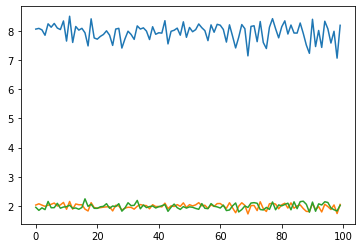

In [3]:
plt.plot(normal_data.T)

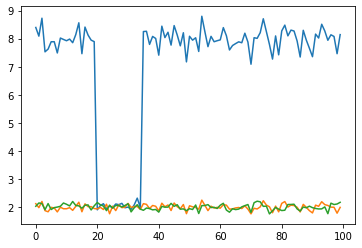

In [4]:
plt.plot(abnormal_data.T)

# Fit detector on normal data

We need normal data without anomalies to fit the detector so that the detector is able to learn the typical correlations to expect when data does not contain anomalies.

In [5]:
detector = MVCorrelationDetector(5)
detector.fit(normal_data)

# Run detector on abnormal data and visualize

In [6]:
detections = detector.detect(abnormal_data)
any_ts_anomalous = np.any(detections, axis=1)

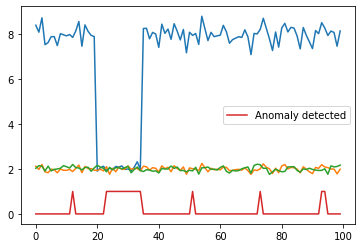

In [7]:
plt.plot(abnormal_data.T)
plt.plot(any_ts_anomalous, label='Anomaly detected')
plt.legend()

As seen in the above figure, there are some detections where the data is normal and not all time points in the anomalous window are detected. Since the windows used to calculate the cross-correlations are quite small, substantial uncertainty in the cross-correlation estimates is to be expected. Random fluctuation in estimates within this uncertainty cause some anomalous time points to be missed and some normal time points to be flagged. To obtain a better overview of where anomalies time periods arise, some post-processing that aggregates individual detections is necessary to decrease the effect of uncertainty in the cross-correlation estimates.

## Post-process detections and visualize

In this case, we a threshold on the proportion of detections in a window to decide whether the window is anomalous or not. These values will probably need to be tuned specifically for a new dataset.

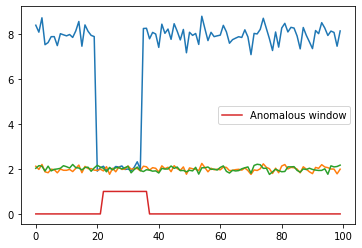

In [8]:
plt.plot(abnormal_data.T)
plt.plot(any_ts_anomalous.rolling(10, center=True).mean() > 0.3, label='Anomalous window')
plt.legend()

# Run detector on normal data and visualize

While we want to make sure we detect anomalies in the normal data, we also want to check that we do not make (too many) detections in normal data. This is what we inspect in the following.

In [9]:
detections = detector.detect(normal_data)
any_ts_anomalous = np.any(detections, axis=1)

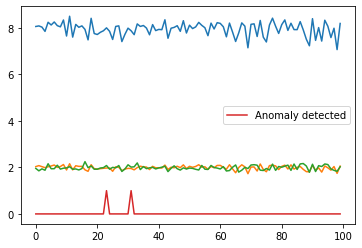

In [10]:
plt.plot(normal_data.T)
plt.plot(any_ts_anomalous, label='Anomaly detected')
plt.legend()

A few points in the normal data were detected as anomalous.

## Post-process detections and visualize

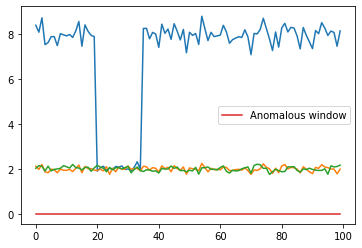

In [11]:
plt.plot(abnormal_data.T)
plt.plot(any_ts_anomalous.rolling(10, center=True).mean() > 0.3, label='Anomalous window')
plt.legend()

After post-processing, we see that no anomalous windows were found.